In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import emoji
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer



In [25]:
new = False
if new:
    df = pd.read_csv("../data/new_data.csv")
    df["labels"] = df["labels"].str.strip()
    df["labels"] = df["labels"].str.replace("neutra", "neutral", regex=True)
    df["labels"] = df["labels"].str.replace("neutrall", "neutral", regex=True)
    # df.labels.value_counts()
    df_new_neg = df[df.labels == "negative"][:16063]
    df_new_pos = df[df.labels == "positive"]
    df_redu = pd.concat([df_new_neg, df_new_pos])
    # df_redu.labels.value_counts()
else:
    df = pd.read_csv("../data/amahric_testdata.csv")
    df["labels"] = df["labels"].str.strip()
    df["labels"] = df["labels"].str.replace("strongNegative", "negative", regex=True)
    df["labels"] = df["labels"].str.replace("neutral", "positive", regex=True)
    df["labels"] = df["labels"].str.replace("strongPositive", "positive", regex=True)


In [26]:
df.labels.value_counts()

positive    14524
negative    14154
Name: labels, dtype: int64

In [27]:
if new:   
    df_redu = df_redu.sample(frac=1).reset_index(drop=True)
else:
    # df_redu = df[df.labels != "neutral"]
    df_redu = df.copy()
    df_redu = df_redu.sample(frac=1).reset_index(drop=True)
df_redu.head()

,texts,labels
0,ምን ዋጋ አለ ? በቀጠይ የምመጡ መሪወች ግድቡን ለግብፅና ለሱደን ሽጠውት...,positive
1,አንግዳውስ ጋሞ ማለት ወደ አማረኛ ስናመጣው አንበሳ ማለት ነው በመሆኑም...,positive
2,በቃ ደስታ ላይ ነኝ,positive
3,ዛሬ ኦርቶዶክሳዊያን ሲጨነቁ ቀርቦ ያልዘገቡ፣ባላየ ባልሰማ ያለፉ የመንግሥ...,positive
4,እኔ ጠቆይ አልቀልብ ምን አውቃለሁ ደግሞ ምን አገባኝ ለነገሩ ኢትዮጵያ ዋ...,negative


In [28]:
STOP_WORDS = set(
    """
ግን አንቺ አንተ እናንተ ያንተ ያንቺ የናንተ ራስህን ራስሽን ራሳችሁን
ሁሉ ኋላ በሰሞኑ አሉ በኋላ ሁኔታ በኩል አስታውቀዋል ሆነ በውስጥ
አስታውሰዋል ሆኑ ባጣም እስካሁን ሆኖም በተለይ አሳሰበ ሁል በተመለከተ
አሳስበዋል ላይ በተመሳሳይ አስፈላጊ ሌላ የተለያየ አስገነዘቡ ሌሎች የተለያዩ
አስገንዝበዋል ልዩ ተባለ አብራርተዋል መሆኑ ተገለጸ አስረድተዋል  ተገልጿል
ማለቱ ተጨማሪ እባክህ የሚገኝ ተከናወነ እባክሽ ማድረግ ችግር አንጻር ማን
ትናንት እስኪደርስ ነበረች እንኳ ሰሞኑን ነበሩ እንኳን ሲሆን ነበር እዚሁ ሲል
ነው እንደገለጹት አለ ና እንደተናገሩት ቢሆን ነገር እንዳስረዱት ብለዋል ነገሮች
እንደገና ብዙ ናት ወቅት ቦታ ናቸው እንዲሁም በርካታ አሁን እንጂ እስከ
ማለት የሚሆኑት ስለማናቸውም ውስጥ ይሆናሉ ሲባል ከሆነው ስለዚሁ ከአንድ
ያልሆነ ሳለ የነበረውን ከአንዳንድ በማናቸውም በሙሉ የሆነው ያሉ በእነዚሁ
ወር መሆናቸው ከሌሎች በዋና አንዲት ወይም
በላይ እንደ በማቀድ ለሌሎች በሆኑ ቢሆንም ጊዜና  ይሆኑበታል በሆነ አንዱ
ለዚህ ለሆነው ለነዚህ ከዚህ የሌላውን ሶስተኛ አንዳንድ ለማንኛውም የሆነ ከሁለት
የነገሩ ሰኣት አንደኛ እንዲሆን እንደነዚህ ማንኛውም ካልሆነ የሆኑት  ጋር ቢያንስ
ይህንንም እነደሆነ እነዚህን ይኸው  የማናቸውም
በሙሉም ይህችው በተለይም አንዱን የሚችለውን በነዚህ ከእነዚህ በሌላ
የዚሁ ከእነዚሁ ለዚሁ በሚገባ ለእያንዳንዱ የአንቀጹ ወደ ይህም ስለሆነ ወይ
ማናቸውንም ተብሎ እነዚህ መሆናቸውን የሆነችን ከአስር ሳይሆን ከዚያ የለውም
የማይበልጥ እንደሆነና እንዲሆኑ  በሚችሉ ብቻ ብሎ ከሌላ የሌላቸውን
ለሆነ በሌሎች ሁለቱንም በቀር ይህ በታች አንደሆነ በነሱ
ይህን የሌላ እንዲህ ከሆነ ያላቸው በነዚሁ በሚል የዚህ ይህንኑ
በእንደዚህ ቁጥር ማናቸውም ሆነው ባሉ በዚህ በስተቀር ሲሆንና
በዚህም መሆን ምንጊዜም እነዚህም በዚህና ያለ ስም
ሲኖር ከዚህም መሆኑን በሁኔታው የማያንስ እነዚህኑ ማንም ከነዚሁ
ያላቸውን እጅግ ሲሆኑ ለሆኑ ሊሆን  ለማናቸውም እና ነዉ እኔ
""".split()
)

In [29]:
X = df_redu.texts.values
labels = df_redu.labels.values
encoded_labels = []
for label in labels:
    if label == "negative":
        encoded_labels.append(0)
    else:
        encoded_labels.append(1)
y = np.array(encoded_labels)

In [30]:
def filter_stop_words(ls):
    new_ls_stop = []
    for input in ls:
        cleaned = [w for w in input.split(" ") if not w in STOP_WORDS]
        new_ls_stop.append(" ".join(cleaned).strip())

    return new_ls_stop
    
def remove_emojis(ls):
    new_ls = []
    for input in ls:
        new_ls.append(emoji.replace_emoji(input)
)
    return new_ls
    
def remove_punc_and_special_chars(ls): 
    new_ls = []
    for text in ls:
        text = str(text)
        normalized_text = re.sub('[\!\@\#\$\%\^\«\»\&\*\(\)\…\[\]\{\}\;\“\”\›\’\‘\"\'\:\,\.\‹\/\<\>\?\\\\|\`\´\~\-\=\+\፡\።\፤\;\፦\፥\፧\፨\፠\፣]', '',text)
        new_ls.append(normalized_text)
    return new_ls

def remove_ascii_and_numbers(ls):
    new_ls = []
    for text_input in ls:
        text_input = str(text_input)
        rm_num_and_ascii=re.sub('[A-Za-z0-9]','',text_input)
        text = re.sub('[\'\u1369-\u137C\']+','',rm_num_and_ascii)
        new_ls.append(text)
    return new_ls

def normalize_char_level_missmatch(ls):
        new_ls = []
        for input_token in ls:
                input_token = str(input_token)
                rep1=re.sub('[ሃኅኃሐሓኻ]','ሀ',input_token)
                rep2=re.sub('[ሑኁዅ]','ሁ',rep1)
                rep3=re.sub('[ኂሒኺ]','ሂ',rep2)
                rep4=re.sub('[ኌሔዄ]','ሄ',rep3)
                rep5=re.sub('[ሕኅ]','ህ',rep4)
                rep6=re.sub('[ኆሖኾ]','ሆ',rep5)
                rep7=re.sub('[ሠ]','ሰ',rep6)
                rep8=re.sub('[ሡ]','ሱ',rep7)
                rep9=re.sub('[ሢ]','ሲ',rep8)
                rep10=re.sub('[ሣ]','ሳ',rep9)
                rep11=re.sub('[ሤ]','ሴ',rep10)
                rep12=re.sub('[ሥ]','ስ',rep11)
                rep13=re.sub('[ሦ]','ሶ',rep12)
                rep14=re.sub('[ዓኣዐ]','አ',rep13)
                rep15=re.sub('[ዑ]','ኡ',rep14)
                rep16=re.sub('[ዒ]','ኢ',rep15)
                rep17=re.sub('[ዔ]','ኤ',rep16)
                rep18=re.sub('[ዕ]','እ',rep17)
                rep19=re.sub('[ዖ]','ኦ',rep18)
                rep20=re.sub('[ጸ]','ፀ',rep19)
                rep21=re.sub('[ጹ]','ፁ',rep20)
                rep22=re.sub('[ጺ]','ፂ',rep21)
                rep23=re.sub('[ጻ]','ፃ',rep22)
                rep24=re.sub('[ጼ]','ፄ',rep23)
                rep25=re.sub('[ጽ]','ፅ',rep24)
                rep26=re.sub('[ጾ]','ፆ',rep25)
                #Normalizing words with Labialized Amharic characters such as በልቱዋል or  በልቱአል to  በልቷል  
                rep27=re.sub('(ሉ[ዋአ])','ሏ',rep26)
                rep28=re.sub('(ሙ[ዋአ])','ሟ',rep27)
                rep29=re.sub('(ቱ[ዋአ])','ቷ',rep28)
                rep30=re.sub('(ሩ[ዋአ])','ሯ',rep29)
                rep31=re.sub('(ሱ[ዋአ])','ሷ',rep30)
                rep32=re.sub('(ሹ[ዋአ])','ሿ',rep31)
                rep33=re.sub('(ቁ[ዋአ])','ቋ',rep32)
                rep34=re.sub('(ቡ[ዋአ])','ቧ',rep33)
                rep35=re.sub('(ቹ[ዋአ])','ቿ',rep34)
                rep36=re.sub('(ሁ[ዋአ])','ኋ',rep35)
                rep37=re.sub('(ኑ[ዋአ])','ኗ',rep36)
                rep38=re.sub('(ኙ[ዋአ])','ኟ',rep37)
                rep39=re.sub('(ኩ[ዋአ])','ኳ',rep38)
                rep40=re.sub('(ዙ[ዋአ])','ዟ',rep39)
                rep41=re.sub('(ጉ[ዋአ])','ጓ',rep40)
                rep42=re.sub('(ደ[ዋአ])','ዷ',rep41)
                rep43=re.sub('(ጡ[ዋአ])','ጧ',rep42)
                rep44=re.sub('(ጩ[ዋአ])','ጯ',rep43)
                rep45=re.sub('(ጹ[ዋአ])','ጿ',rep44)
                rep46=re.sub('(ፉ[ዋአ])','ፏ',rep45)
                rep47=re.sub('[ቊ]','ቁ',rep46) #ቁ can be written as ቊ
                rep48=re.sub('[ኵ]','ኩ',rep47) #ኩ can be also written as ኵ  
                new_ls.append(rep48)
        return new_ls

In [31]:
X = remove_punc_and_special_chars(X)
X = remove_ascii_and_numbers(X)
X = remove_emojis(X)
X = filter_stop_words(X)
len(X)

28682

In [32]:
for sentence in X:
    if "ነው " in sentence:
        print(sentence)

ም እያሉ  አለፈው አጀንዳቸው ምን እንደሆነ አይታወቅም እነ አብን አዴፖ ግንቦት  ቅድሚያ ሰጥተውት ለማጨናገፍ እየሰሩ  ታዲያ በረራ ቢባል የፊንፊኔ ጉዳይ ይቀራል ብለህ ታስባለህ በእውነቱ የ አመት በፊት የምትታወቅበትን ትቶ  አመት ወደኋላ በመሄድ በረራ በረራ ምንድነው ሚስጥሩ  የሀበሾች የፀረ ኦሮሞ ትግል አካል ነዋ እንደተለመደው አንድ የሀበሻ ፕሮፌሰር በዚሁ መፅሐፍ እየደረሰ  የነብልናል ብለው  እራሳቸው አበሾቹ ናቸዋ ለመሸጥ ምን አለው የአሁኑ ዘመን ቄሮዎች አጄቶዎች  እንደሆነ ተረቱን ለማንበብ የሚያጠፉት ጊዜ የላቸውም   እንዲያው ከንቱ ልፋት አይሆንባቸውም ብለህ አባቶቻቸው ግዛታቸውን አስፋፍተው ያስገበሩትንና የወረሱትን ታሪክና የኢኮኖሚ የባህል የቋንቋ  የበላይነት ለማስቀጠል ተስፋ አይቆርጡም እነሱ እያሉ ያሉት በማንኛውም መልኩ ተንጫጭተንም ተፋልመን ኢትዮጵያን ዱሮ ከፍታዋ እንመልሳለን የበላይነታችንንም ዳግም እናረጋግጣለን ዱሮ ዝናዋ የመመለስ ራዕይ በዶር አብያችን መሪነት እውን ይሆናል ብለው ያስባሉ
ምነው ሊመሽ ስል ዘገባችሁ ጠዋት ጥሩ
በመኪናም በትንታ መሞቴ እንደሁ አይቀርም ወሃቢያም መሞቱ አይቀርም የተወለድኩት ለመሞት ሞትን ለሚፈሩር ለወገኖችህ ንገራቸው ደግሞ ዘመን ምን የሚያስቀና አለናነነው ለመኖር የምመኘው ጎጋ ነህ
ስፖርት የካቲት  ቀን  ዓም አንጋፋው የቅዱስ ጊዮርጊስ ስፖርት ማኅበር ባከናወነው ጠቅላላ ጉባኤ ሼር ኩባንያ ተቀይሮ ገሚሱ ድርሻ ለቡድኑ ደጋፊዎች የቀረው ደግሞ ለባለ ሐብቶች ሊሸጥ መታቀዱ ተገልጧል የሳዑዲ ዓረቢያው አልጋ ወራሽ ልዑል በእንግሊዝ ፕሬሚየር ሊግ ማንቸስተር ዩናይትድን ሊገዙት የሚል ዘገባ የቡድኑ ደጋፊዎችን አስቆጥቷል
ዛሬ ለኛ ጊዜ ፍርድ ቤት የቀረቡት እነ አቶ በረከት ለሰኞ ተቀጠሩ የአማራ ክልል ስነ ምግባርና ፀረሙ

In [33]:
df_clean = pd.DataFrame()
df_clean["clean"] = pd.DataFrame(X)
df_clean["labels"] = pd.DataFrame(y)
df_clean.head()
# df_clean = pd.DataFrame([X, labels], columns= ['text','labels'])


,clean,labels
0,ምን ዋጋ በቀጠይ የምመጡ መሪወች ግድቡን ለግብፅና ለሱደን ሽጠውት ለኖቤ...,1
1,አንግዳውስ ጋሞ አማረኛ ስናመጣው አንበሳ በመሆኑም ሰውየው የአንበሳን ሙያ,1
2,በቃ ደስታ ነኝ,1
3,ዛሬ ኦርቶዶክሳዊያን ሲጨነቁ ቀርቦ ያልዘገቡባላየ ባልሰማ ያለፉ የመንግሥት...,1
4,ጠቆይ አልቀልብ ምን አውቃለሁ ደግሞ ምን አገባኝ ለነገሩ ኢትዮጵያ ዋንጫው...,0


In [34]:
print("Creating word clouds...")
negative_words = " ".join(df_clean[df_clean.labels ==0]['clean'].values)
postive_words = " ".join(df_clean[df_clean.labels ==1]['clean'].values)
# words =" ".join(df_clean['clean'].values)



Creating word clouds...


In [35]:
len(negative_words)

903767

In [36]:
len(postive_words)

786645

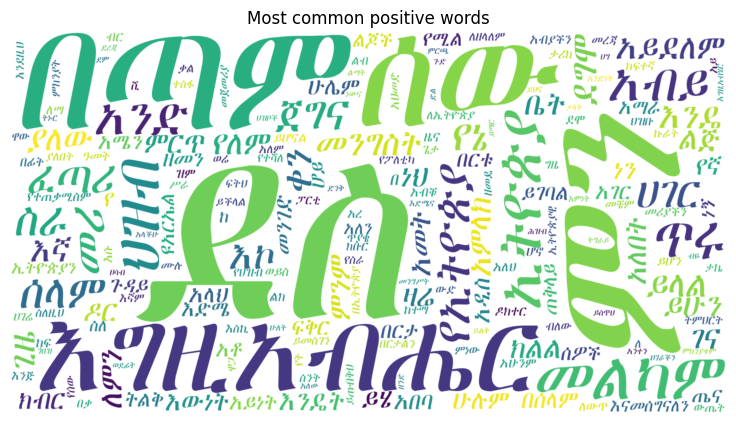

In [37]:

positive_wordcloud = WordCloud(font_path='../fonts/jiretsl.ttf',
                      relative_scaling = 1.0,
                      min_font_size=4,
                      background_color="white",
                      width=744,
                      height=400,
                      scale=3,
                      font_step=1,
                      collocations=False,
                      margin=2
                      ).generate(postive_words)

plt.figure(figsize=(10,5))
plt.imshow(positive_wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.title("Most common positive words")
plt.show()

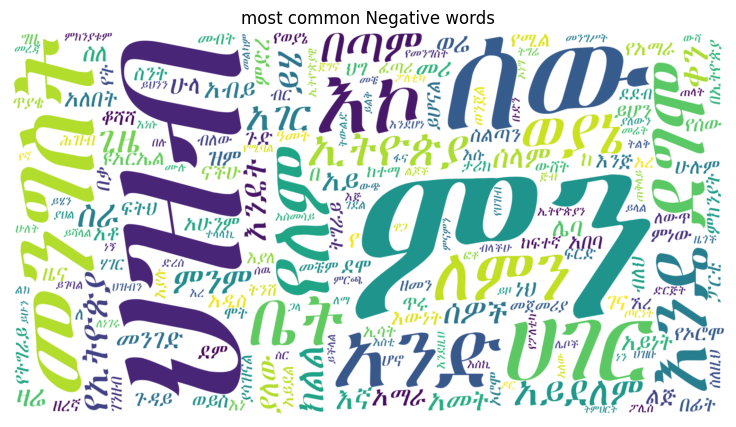

In [38]:
wordcloud = WordCloud(font_path='../fonts/jiretsl.ttf',
                      relative_scaling = 1.0,
                      min_font_size=4,
                      background_color="white",
                      width=744,
                      height=400,
                      scale=3,
                      font_step=1,
                      collocations=False,
                      margin=2
                      ).generate(negative_words)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.title("most common Negative words")
plt.show()


In [12]:
def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [14]:
vectorizer = TfidfVectorizer(max_features=10000)

# Fit the vectorizer to the preprocessed data
X = vectorizer.fit_transform(X).toarray()


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
X.max()

1.0

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train[0]

'ሻደይ የሚለው ቃል ከ ሻይደን የሚል የ ትግርኛ ቃል የመጣ ሻይደን ኣበባየ ሻይደን ከሚል ዘፈን ተወስዶ ከጊዜ ሻደይ ሚለው ተቀየረኣሸንድዬም ኣሸንዳ ለማለት ሽረ ለማለት ሽሬ መቐለ ለማለት መቐሌ ይሉት የለ ኣሸንዳም ኣሸንድዬ ኣሉት ሶለል ደሞ ሰለል ከሚል የ ትግርኛ ቃል የመጣ ሰለል ተጋሩ ከእስክስታው በፊት ክብ ሰርተን የምንጨፍረው ሰለል ኣብሎ ስለል እሚል የድሮ ዘፈን ኣሁንም ይዘፈናልበ ትግራይ ኣጎራባች በቆቦ ኣከባቢ ይዘፈን ነበርኩ ከጊዜ ሰለል ሚለው ሶለል እየተቀየረ ሄደ ይሀው ነውኣዳሜ ንሚድያ ጋጋታ ኝኝ ብትይም ምትጠቀሚው ትግርኛውን'

In [22]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)


TypeError: 'Tokenizer' object is not subscriptable

In [24]:
tokenizer.word_index

{'ምን': 1,
 'ህዝብ': 2,
 'ሰው': 3,
 'በጣም': 4,
 'መንግስት': 5,
 'ኢትዮጵያ': 6,
 'ሀገር': 7,
 'ደስ': 8,
 'አንድ': 9,
 'እኮ': 10,
 'የለም': 11,
 'ስራ': 12,
 'አብይ': 13,
 'እንዴ': 14,
 'ለምን': 15,
 'ጥሩ': 16,
 'መሪ': 17,
 'ደግሞ': 18,
 'የኢትዮጵያ': 19,
 'ሰላም': 20,
 'አይደለም': 21,
 'ክልል': 22,
 'ቤት': 23,
 'እግዚአብሔር': 24,
 'ምንም': 25,
 'ቀን': 26,
 'ያለው': 27,
 'እኛ': 28,
 'መልካም': 29,
 'ጊዜ': 30,
 'ፈጣሪ': 31,
 'አገር': 32,
 'እንዴት': 33,
 'ይሄ': 34,
 'ልጅ': 35,
 'አለበት': 36,
 'አማራ': 37,
 'ነህ': 38,
 'ጀግና': 39,
 'አመት': 40,
 'አይ': 41,
 'ዛሬ': 42,
 'መንገድ': 43,
 'ሁሉም': 44,
 'ገና': 45,
 'እውነት': 46,
 'የ': 47,
 'ደም': 48,
 'ሰዎች': 49,
 'ወያኔ': 50,
 'ወሬ': 51,
 'ስለ': 52,
 'ዝም': 53,
 'አይነት': 54,
 'ጉዳይ': 55,
 'ይላል': 56,
 'በ': 57,
 'አበባ': 58,
 'አዲስ': 59,
 'ይሁን': 60,
 'አሁንም': 61,
 'ዘመን': 62,
 'ነን': 63,
 'ከ': 64,
 'ዶር': 65,
 'አምላክ': 66,
 'እንጅ': 67,
 'የሰው': 68,
 'የአማራ': 69,
 'ፍትህ': 70,
 'በቃ': 71,
 'ይገባል': 72,
 'አቶ': 73,
 'የሚል': 74,
 'የት': 75,
 'የኔ': 76,
 'ይሆን': 77,
 'ክብር': 78,
 'ወይስ': 79,
 'ዜና': 80,
 'ምነው': 81,
 'ኢትዮጵያን': 82,
 'ምርጥ': 83,
 'የኛ': 84,
 'ሌባ': 85,

In [23]:
tokenizer

In [30]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 10

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [31]:
X_train[0]

array([10508, 26217, 26218, 26219,  3080, 26220, 10509, 10510, 26221,
          44], dtype=int32)

In [ ]:
# Define the SVM model
svm = SVC(kernel='linear', C=1, random_state=42)

# Train the model on the training data
svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm.predict(X_test)

# Evaluate the model using accuracy and F1 score
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")




In [25]:
# Define the Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model using accuracy and F1 score
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.4994
F1 score: 0.5109


In [26]:

# Define the Logistic Regression model
lr = LogisticRegression(penalty='l2', C=1.0, random_state=42)

# Train the model on the training data
lr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test)

# Evaluate the model using accuracy and F1 score
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.4994
F1 score: 0.4519
